In [1]:
using PyPlot
using LinearAlgebra
using Statistics
using Random
using Profile

In [2]:
const σ0 = ComplexF64[1 0; 0 1]
const σ1 = ComplexF64[0 1; 1 0]
const σ2 = ComplexF64[0 -1im; 1im 0]
const σ3 = ComplexF64[1 0; 0 -1];

In [3]:
function state_update_under_mesurement(state, basis, n_step)
    sequence = Array{ComplexF64, 1}[]
    s0 = basis[:, 1]
    s1 = basis[:, 2]

    for _ in 1:n_step
        push!(sequence, copy(state))
        if rand_ghz && (rand()<0.5)
            state[1], state[2] = state[2], state[1]
        end
        p = abs(state' * s0)^2
        if rand() < p
            state[1] *= s0[1]
            state[2] *= s0[2]
        else
            state[1] *= s1[1]
            state[2] *= s1[2]
        end
        state ./= norm(state)
    end
    return sequence
end


function GHZ_MIE(basis, n_step, rand_ghz=true)
    state = ComplexF64[1, 1] ./ sqrt(2)
    s0 = basis[:, 1]
    s1 = basis[:, 2]

    for _ in 1:n_step
        if rand_ghz && (rand()<0.5)
            state[1], state[2] = state[2], state[1]
        end
        p = abs(state' * s0)^2
        if rand() < p
            state[1] *= s0[1]
            state[2] *= s0[2]
        else
            state[1] *= s1[1]
            state[2] *= s1[2]
        end
        state ./= norm(state)
    end
    eps = 1e-64
    a = abs(state[1])^2
    b = abs(state[2])^2
    return - a * log2(a+eps) - b * log2(b+eps)
end



function process_states(sequence)
    tmp = Float64[]
    for state in sequence
        push!(tmp, min(abs(state[1]), abs(state[2])))
    end
    return tmp
end

m2s(i) = div(i+1, 2)
s2m(i) = 2i-1


function product_state(n)
    state = Array{Int}(1:n)
    state[1:2:end], state[2:2:end] = state[2:2:end], state[1:2:end]
    return state
end


function one_layer_update!(state, p, q, periodic=true)
    n = size(state, 1)
    for i in 1:2:n
        j =  i%n+1
        if (j==1) && !periodic
            continue
        end
        a, b = state[i], state[j]
        (a == j) && continue
        if rand() < p
            state[i], state[j] = b, a
            state[a], state[b] = j, i
        elseif rand() < q
            state[a], state[b] = b, a
            state[i], state[j] = j, i
        end
    end
    for i in 2:2:n
        j =  i%n+1
        if (j==1) && !periodic
            continue
        end
        a, b = state[i], state[j]
        (a == j) && continue
        if rand() < p
            state[i], state[j] = b, a
            state[a], state[b] = j, i
        elseif rand() < 1-q
            state[a], state[b] = b, a
            state[i], state[j] = j, i
        end
    end
    return state
end


function sample_arcs(n)
    state = product_state(2n)
    for _ in 1:2n
        one_layer_update!(state, 0, 0.5)
    end
    return state
end


function cal_MIE_MI_MN(state, avg, A, B, basis)
    n = div(size(state, 1), 2)
    saw = zeros(Bool, n)
    MIE = 0.
    MI = 0.
    MN = 0.
    c=0

    for i in 1:n
        if saw[i]
            continue
        end
                
        c = 0
        tA = false
        tB = false
        
        if (i in A)
            tA = true
        elseif (i in B)
            tB = true
        else
            c = c+1
        end
        
        saw[i] = true
        j = m2s(state[2i])
        
        
        while j != i
            saw[j] = true

            if (j in A)
                tA = true
            elseif (j in B)
                tB = true
            else
                c = c+1
            end
            j = m2s(state[2j])
        end

        if tA && tB
            tmp = 0.
            for _ in 1:avg
                tmp += GHZ_MIE(basis, c)
            end
            MIE += tmp / avg
            MI += (c==0 ? 2 : 1)
            MN += (c==0 ? 1 : 0)
        end
    end     
    return MIE, MI, MN
end

function cross_ratio(A, B, n)
    x1, x2 = A.start, A.stop+1
    x3, x4 = B.start, B.stop+1
    f(x,y) = n/pi * sin(abs(x-y)*pi/n)
    w12 = f(x1, x2)
    w34 = f(x3, x4)
    w13 = f(x1, x3)
    w24 = f(x2, x4)
    return w12*w34/w13/w24
end


function antipodal_sim(basis_list, n, n_average, rd_list)
    MIEs = zeros(Float64,  length(rd_list), length(basis_list))
    MIs = zeros(Float64, length(rd_list))
    MNs = zeros(Float64, length(rd_list))
    for _ in 1:n_average
        state = sample_arcs(n)
        for (j, rd) in enumerate(rd_list)
            A = 1:rd
            B = div(n,2)+1:div(n,2)+rd
            for (k, basis) in enumerate(basis_list)
                MIE, MI, MN = cal_MIE_MI_MN(state, div(n,8), A, B, basis)
                MIEs[j,k] += MIE
                MIs[j] += MI
                MNs[j] += MN
            end
        end
    end
    MIEs ./= n_average
    MIs ./= n_average * length(basis_list)
    MNs ./= n_average * length(basis_list)
    return MIEs, MIs, MNs
end

antipodal_sim (generic function with 1 method)

In [405]:
n = 128
n_average = 1000
rd_list = 2:2:div(n,2)
basis = [eigvecs(σ1+σ2+0.5σ3)]

# Random.seed!(4)
Profile.clear()
@profile result = antipodal_sim(basis, n, n_average, rd_list)

([0.0010145257347802322; 0.002357475520172123; … ; 0.9841932063843443; 1.846], [0.088, 0.141, 0.18, 0.218, 0.261, 0.291, 0.321, 0.35, 0.372, 0.395  …  0.794, 0.834, 0.893, 0.949, 1.033, 1.136, 1.254, 1.425, 1.748, 3.692], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001, 0.001  …  0.036, 0.045, 0.059, 0.07, 0.101, 0.132, 0.175, 0.24, 0.366, 1.846])

In [406]:
Profile.print(mincount=1000)

Overhead ╎ [+additional indent] Count File:Line; Function
   ╎1175 @Base\task.jl:356; (::IJulia.var"#15#18")()
   ╎ 1175 ...lia\src\eventloop.jl:8; eventloop(::ZMQ.Socket)
   ╎  1175 @Base\essentials.jl:709; invokelatest
   ╎   1175 @Base\essentials.jl:710; #invokelatest#1
   ╎    1175 ...\execute_request.jl:67; execute_request(::ZMQ.Socket, ...
   ╎     1175 ...SoftGlobalScope.jl:65; softscope_include_string(::Mo...
   ╎    ╎ 1175 @Base\loading.jl:1091; include_string(::Function, ...
Total snapshots: 1176


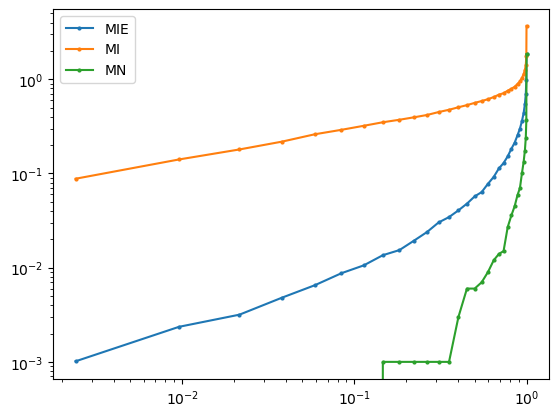

PyObject <matplotlib.legend.Legend object at 0x000000006491AD60>

In [407]:
fg, ax = subplots(1,1)


x = [cross_ratio(1:rd, div(n,2)+1:div(n,2)+rd, n) for rd in rd_list]
y1, y2, y3 = result

ax.plot(x, y1, "-o", label="MIE", ms=2)
ax.plot(x, y2, "-o", label="MI", ms=2)
ax.plot(x, y3, "-o", label="MN", ms=2)

# ax.plot(x, x.^(2))

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

In [368]:
@code_warntype sample_arcs(10)

Variables
  #self#::Core.Compiler.Const(sample_arcs, false)
  n::Int64
  state::Array{Int64,1}
  @_4::Union{Nothing, Tuple{Int64,Int64}}

Body::Array{Int64,1}
1 ─ %1  = (2 * n)::Int64
│         (state = Main.product_state(%1))
│   %3  = (2 * n)::Int64
│   %4  = (1:%3)::Core.Compiler.PartialStruct(UnitRange{Int64}, Any[Core.Compiler.Const(1, false), Int64])
│         (@_4 = Base.iterate(%4))
│   %6  = (@_4 === nothing)::Bool
│   %7  = Base.not_int(%6)::Bool
└──       goto #4 if not %7
2 ┄ %9  = @_4::Tuple{Int64,Int64}::Tuple{Int64,Int64}
│         Core.getfield(%9, 1)
│   %11 = Core.getfield(%9, 2)::Int64
│         Main.one_layer_update!(state, 0, 0.5)
│         (@_4 = Base.iterate(%4, %11))
│   %14 = (@_4 === nothing)::Bool
│   %15 = Base.not_int(%14)::Bool
└──       goto #4 if not %15
3 ─       goto #2
4 ┄       return state


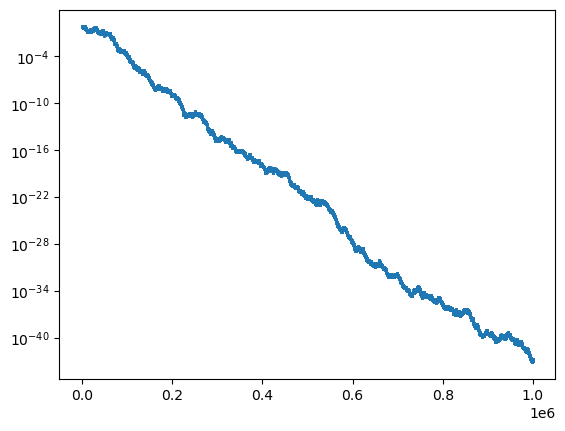

In [163]:
state = ComplexF64[1, 1] ./ sqrt(2)
basis = eigvecs(σ1 + 0.01σ3)
rand_ghz = true
n_step = 1000000

sequence = state_update_under_mesurement(state, basis, n_step)
tmp = process_states(sequence)

x = 1:n_step
y = tmp

plot(x,y, ms=1,"o")
yscale("log")

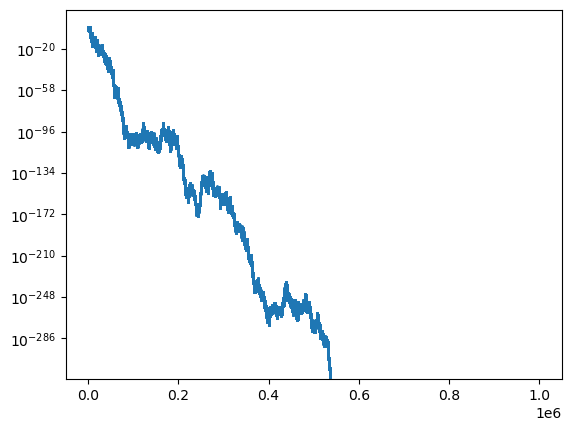

In [164]:
state = ComplexF64[1, 1] ./ sqrt(2)
basis = eigvecs(σ1 + 0.01σ3 + σ2)
rand_ghz = true
n_step = 1000000

sequence = state_update_under_mesurement(state, basis, n_step)
tmp = process_states(sequence)

x = 1:n_step
y = tmp

plot(x,y, ms=1,"o")
yscale("log")

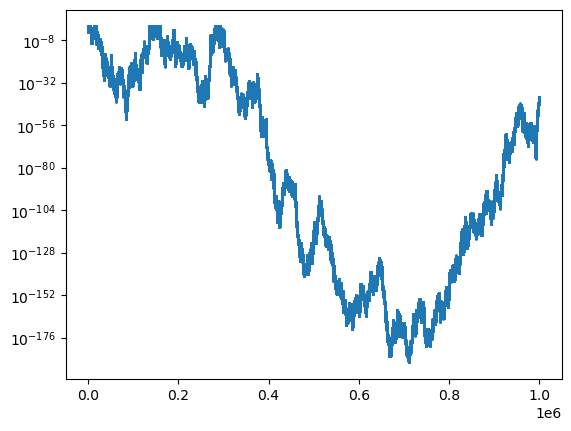

In [144]:
state = ComplexF64[1, 1] ./ sqrt(2)
basis = eigvecs(σ1 +  σ2)
rand_ghz = true
n_step = 1000000

sequence = state_update_under_mesurement(state, basis, n_step)
tmp = process_states(sequence)

x = 1:n_step
y = tmp

plot(x,y, ms=1,"o")
yscale("log")

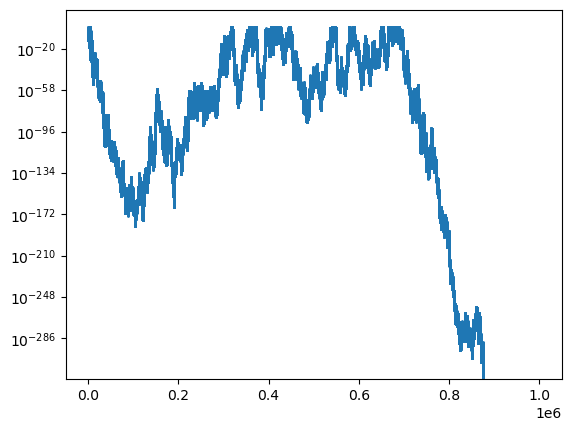

In [165]:
state = ComplexF64[1, 1] ./ sqrt(2)
basis = eigvecs(σ1 +  2σ2)
rand_ghz = true
n_step = 1000000

sequence = state_update_under_mesurement(state, basis, n_step)
tmp = process_states(sequence)

x = 1:n_step
y = tmp

plot(x,y, ms=1,"o")
yscale("log")

In [188]:
n = 32
A = 1:div(n, 4)
B = div(n, 2)+1:3*div(n,4)
avg = 10

basis = eigvecs(σ1 +  2σ2)
state = sample_arcs(n)
cal_MIE(state, avg, A, B, basis)


0

In [5]:
mybinomial = binomial

function GHZ_MIE(p, c, k)
    eps=1e-12
    lg(x) = log2(x+eps)
    a(n) = p^n * (1-p)^(c-n)
    b(n) = (1-p)^n * p^(c-n)
    
    if isone(k)
        SAC = c * (- p * lg(p) - (1-p) * lg(1-p)) + 1
        SC = begin
            tmp = 0.
            for n in 0:c
                tmpp = (a(n) + b(n)) / 2
                tmp += (- tmpp * lg(tmpp)) * mybinomial(c, n)
            end
            tmp
        end
    else
        SAC = 1/(1-k) * (c * lg(p^k + (1-p)^k) + 1 - k)
        SC = 1/(1-k) * (lg(
            begin
                tmp = 0.
                for n in 0:c
                    tmpp = (a(n) + b(n))^k
                    tmp += tmpp * mybinomial(c, n)
                end
                tmp
            end
            ) - k)
    end
    return SAC - SC
end

GHZ_MIE (generic function with 2 methods)

In [9]:
p = 0.5
c=6
k=2
GHZ_MIE(p, c, k)

1.0000000000057714

In [17]:
function GHZ_MIE(p, c, k)
    eps = 1e-64
    lg(x) = log2(x+eps)
    a(n) = p^n * (1-p)^(c-n)
    b(n) = (1-p)^n * p^(c-n)
    
    if isone(k)
        SAC = c * (- p * lg(p) - (1-p) * lg(1-p)) + 1
        SC = begin
            tmp = 0.
            for n in 0:c
                tmpp = (a(n) + b(n)) / 2
                tmp += (- tmpp * lg(tmpp)) * mybinomial(c, n)
            end
            tmp
        end
    else
        SAC = 1/(1-k) * (c * lg(p^k + (1-p)^k) + 1 - k)
        SC = 1/(1-k) * (lg(
            begin
                tmp = 0.
                for n in 0:c
                    tmpp = (a(n) + b(n)) ^ k
                    tmp += tmpp * mybinomial(c, n)
                end
                tmp
            end
            ) - k)
    end
    return SAC - SC
end



# @everywhere function process_states(sequence)
#     tmp = Float64[]
#     for state in sequence
#         push!(tmp, min(abs(state[1]), abs(state[2])))
#     end
#     return tmp
# end

m2s(i) = div(i+1, 2)
s2m(i) = 2i-1


function product_state(n)
    state = Array{Int}(1:n)
    state[1:2:end], state[2:2:end] = state[2:2:end], state[1:2:end]
    return state
end


function one_layer_update!(state, p, q, periodic=true)
    n = size(state, 1)
    for i in 1:2:n
        j =  i%n+1
        if (j==1) && !periodic
            continue
        end
        a, b = state[i], state[j]
        (a == j) && continue
        if rand() < p
            state[i], state[j] = b, a
            state[a], state[b] = j, i
        elseif rand() < q
            state[a], state[b] = b, a
            state[i], state[j] = j, i
        end
    end
    for i in 2:2:n
        j =  i%n+1
        if (j==1) && !periodic
            continue
        end
        a, b = state[i], state[j]
        (a == j) && continue
        if rand() < p
            state[i], state[j] = b, a
            state[a], state[b] = j, i
        elseif rand() < 1-q
            state[a], state[b] = b, a
            state[i], state[j] = j, i
        end
    end
    return state
end


function sample_arcs(n)
    state = product_state(2n)
    for _ in 1:2n
        one_layer_update!(state, 0, 0.5)
    end
    return state
end


function cal_MIE(state, AB_list, ps, ks)
    n = div(size(state, 1), 2)
    saw = zeros(Bool, n)
    
    MIE = zeros(Float64, length(AB_list), length(ps), length(ks))
    
    
    MI = zeros(Float64, length(AB_list))
    MN = zeros(Float64, length(AB_list))
    
    
    cs = zeros(Int, length(AB_list))
    tAs = zeros(Bool, length(AB_list))
    tBs = zeros(Bool, length(AB_list))

    for i in 1:n
        if saw[i]
            continue
        end
        
        cs .= 0
        tAs .= false
        tBs .= false
        
        
        j = i
        while true
#             print(j, " ")
            saw[j] = true

            for (k, AB) in enumerate(AB_list)
                A, B = AB

                if (j in A)
                    tAs[k] = true
                elseif (j in B)
                    tBs[k] = true
                else
                    cs[k] += 1
                end
            end
            j = m2s(state[2j])
            if j==i
                break
            end
        end
#         println("")
        
        for kk in 1:length(AB_list)
            if tAs[kk] && tBs[kk]
                for ii in 1:length(ps), jj in 1:length(ks)
                    # @show cs[kk]
                    MIE[kk, ii, jj] += GHZ_MIE(ps[ii], cs[kk], ks[jj])
                end
                MI[kk] += 1
                MN[kk] += (cs[kk]==0) ? 1 : 0
            end
        end
        # @show cs
    end     
    return MIE, MI, MN
end

function cross_ratio(A, B, n)
    x1, x2 = A.start, A.stop+1
    x3, x4 = B.start, B.stop+1
    f(x,y) = n/pi * sin(abs(x-y)*pi/n)
    w12 = f(x1, x2)
    w34 = f(x3, x4)
    w13 = f(x1, x3)
    w24 = f(x2, x4)
    return w12*w34/w13/w24
end

mybinomial(a,b) = binomial(BigInt(a), BigInt(b))

mybinomial (generic function with 1 method)

In [18]:
n = 256
AB_list = [(1:rd, div(n,2) .+ (1:rd)) for rd in 2:2:div(n,2)]
ps = [0.5]
ks=[1]
avg = 100


state = sample_arcs(n)
tmp = [
    begin
        state = sample_arcs(n)
        cal_MIE(state, AB_list, ps, ks)
    end
        for _ in 1:avg]

MIE, MI, MN = mean([a[1] for a in tmp]), mean([a[2] for a in tmp]), mean([a[3] for a in tmp])

([0.03; 0.03; … ; 1.54; 2.0], [0.03, 0.03, 0.06, 0.07, 0.07, 0.09, 0.11, 0.12, 0.13, 0.15  …  0.83, 0.85, 0.88, 0.92, 1.0, 1.06, 1.14, 1.31, 1.54, 2.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.11, 0.11, 0.12, 0.13, 0.16, 0.18, 0.23, 0.31, 0.44, 2.0])

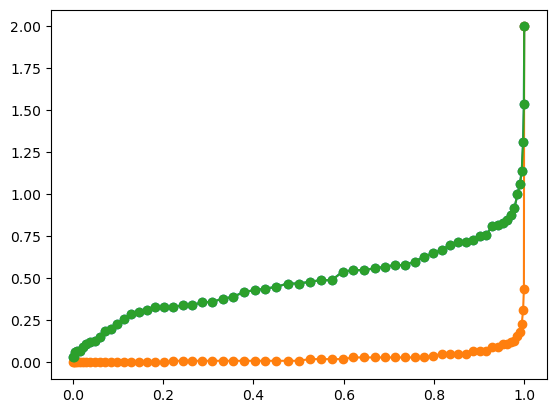

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000000E33340>

In [19]:
crs = [cross_ratio(A, B, n) for (A,B) in AB_list]

m = length(AB_list)

MIE = reshape(MIE, m)
MI = reshape(MI, m)
MN = reshape(MN, m)

plot(crs, MI, "-o")
plot(crs, MN, "-o")
plot(crs, MIE, "-o")